In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels
import scipy
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats
import pylab
from scipy.stats.distributions import chi2
from scipy.stats import norm
from math import sqrt
sns.set()

In [2]:
raw_index_data=pd.read_csv('Index2018.csv')  # Index price data Importation in Raw_index_data variable
df_index=raw_index_data.copy()  # copy to df_index from Raw_index_data
df_index.date=pd.to_datetime(df_index.date,dayfirst=True) # datatype of date column changed to datetime 
df_index.set_index('date',inplace=True) # set date column as index
df_index=df_index.asfreq('b') # setting frequency of data obsevation to business days
df_index.shape #shape checking 

(6277, 4)

In [3]:
df_index.spx.fillna(method='ffill',inplace=True) # front filling of missing values of spx columns
df_index.ftse.fillna(method='bfill',inplace=True) # backfilling of missing values of ftse columns
df_index.dax.fillna(df_index.dax.mean(),inplace=True) # mean value assigned to each missing values of dax columns 
df_index.nikkei.fillna(df_index.nikkei.median(),inplace=True) # median value assigned to each missing value of nikkei

In [4]:
df_market_value=df_index[['ftse']] # Selecting FTSE index for further processing
df_market_value.rename(columns={'ftse':'market_value'},inplace=True) # renaming ftse to market value
traininglen=int(len(df_market_value)*0.8) # Train and test split with ratio of 80:20
testingLen=len(df_market_value)-traininglen
df_market_value_train=df_market_value.iloc[:traininglen,:]
df_market_value_test=df_market_value.iloc[traininglen:,:]

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
mean=df_market_value_train['market_value'].mean() # calculating mean of ftse market index values from training part of dataset
std=df_market_value_train['market_value'].std() # calculating std from same
wn=np.random.normal(loc=mean,scale=std,size=len(df_market_value_train)) # creating white noice using np.random.uniform()
df_market_value_train['wn']=wn # making a new column for white noice which is just created.

C:\Users\adadi\AppData\Local\Temp/ipykernel_12116/3189272835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market_value_train['wn']=wn # making a new column for white noice which is just created.


In [6]:
rw=pd.read_csv('RandWalk.csv') # adding new column for random walk in training dataframe  
rw.date=pd.to_datetime(rw.date,dayfirst=True)
rw.set_index('date',inplace=True)
df_market_value_train=pd.merge(left=df_market_value_train,right=rw,left_index=True, right_index=True)
df_market_value_train.rename(columns={'price':'rw'},inplace=True) # renaming the randomwalk value column

In [7]:
df_market_value_train.head()

,market_value,wn,rw
date,,,
1994-01-07,3445.98,4343.227431,1122.139662
1994-01-10,3440.58,4363.947785,1080.347860
1994-01-11,3413.77,5139.494575,1082.095245
1994-01-12,3372.02,5807.998490,1083.639265
1994-01-13,3360.01,6078.938518,1067.146255


### ***Ploting ACF and PACF Plot On FTSE Index price***

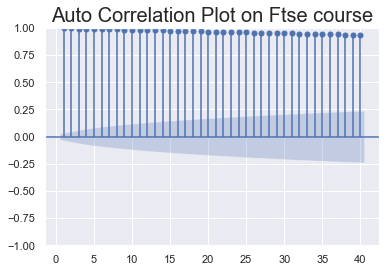

In [8]:
sgt.plot_acf(df_market_value_train.market_value,lags=40,zero=False,use_vlines=True)
plt.title('Auto Correlation Plot on Ftse course',size=20)
plt.show()

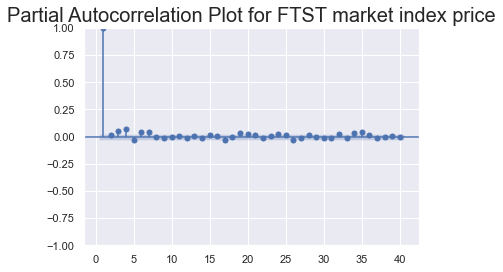

In [9]:
sgt.plot_pacf(df_market_value_train.market_value,lags=40,zero=False,method='ols',alpha=0.05)
plt.title('Partial Autocorrelation Plot for FTST market index price',size=20)
plt.show()

### ***Observation***
- In autocorrelation plot it is observed that current data point has significant correlation(direct and indirect) with previous data points present at different possible lag up to 40.
- So we can predict next time series data using previous upto 40 data points.
- But Partial auto correlation states a different picture Since it takes only the direct effect of the each previous data points.
- It PACF plot shows that it is only last index price which affect significantly current index price. otherwise upto lag 8 pacf has just exceed the threshold limit. upto 40 lag there exist some correlatin which also exceed the threshold value.
- since in PACF we are dealing with direct correaltion between each X(t) and X(t-k) where k in {1,2,..40}, So negative correlation also exit which says that the index price will increase or decease oposite to increase and decrease of price at certain lagpoints.
- Since this pacf value is barely exceed threshold value So we wll avoid to overanalyze it to make the model more parsemonious.
- So we will consider lag up 22 since a month have 22 business days and upto this points pacf plot of reasonable correlation.

### ***Auto Regression Model***
- This model is used to predict future data points by taking past data points as inputs in time series data.
- A normal auto regression model consisist of variable for inputs data mulitplied by some coefficients values.
- Sumation of input past data mulitplied by coefficient value will give future result.
- eq: X(t) = B + X(t-1)*C1 + X(t-2)*C2 +..... + Epsilon0
- |C1| < 1 otherwise value of the output will explode.
- Epsilon0 is the residual( white noice), which is created unexpectedly.

In [10]:
from statsmodels.tsa.arima.model import ARIMA

### ***AR1 Model***

In [11]:
model_ar1=ARIMA(df_market_value_train.market_value,order=(1,0,0),freq='B')
result_ar1=model_ar1.fit()
result_ar1.summary()

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27622.604
Date:                Wed, 23 Oct 2024   AIC                          55251.207
Time:                        15:43:32   BIC                          55270.772
Sample:                    01-07-1994   HQIC                         55258.063
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6981    423.327     12.023      0.000    4259.992    5919.404
ar.L1          0.9984      0.001   1147.577      0.000       0.997       1.000
sigma2      3511.3843     40.874     85.907      0.000    3431.272    3591.496
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              3313.33
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

***Observation***
- Log likelihood value found out to be -27622.604.
- Significance of cofficient and constant values are good. since p value are less than 0.05.
- 95% confidence interval of Coefficient-1 lies between [0.997	1.000]
- And for constant it lies between [4259.992	5919.404]
- So Coefficient are significant

### ***AR2 Model***

In [12]:
model_ar2=ARIMA(df_market_value_train.market_value,order=(2,0,0),freq='B')
result_ar2=model_ar2.fit()
result_ar2.summary()

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -27621.947
Date:                Wed, 23 Oct 2024   AIC                          55251.894
Time:                        15:43:33   BIC                          55277.980
Sample:                    01-07-1994   HQIC                         55261.035
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    368.244     13.822      0.000    4367.956    5811.447
ar.L1          0.9810      0.010     99.872      0.000       0.962       1.000
ar.L2          0.0172      0.010      1.752      0.080      -0.002       0.036
sigma2      3510.1247     41.037     85.536      0.000    3429.694    3590.555
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3282.87
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

***Observation of ar2 model and comparision with ar1***
- Log likelihood value of ar2 is -27621.947 where it was -27622.604 for ar1.
- Since Loglihood has increased so ar2 model has performed well but this performance is significantly better or not, it need to be checked.
- If we considers the value of coefficient 1 and 2 of AR2 Model it is found that coefficient 1 is significant as p value is less than 0.05 but coefficient-2 is not significant cause p value >0.05.
- Lets make it more easy to compare two model by using Log likelihood ratio test.  



***Log Likelihood Ratio Test***
- this test is used to select a better model by comparing their log likelihood value.
- It tested in null hypothesis paradigm.
- test statistics Q=2(Lb-La).
- This test can be performed when one of the two models which is being compared, is a special case another one. And it is also evident from model parameters that model AR1 is a Special case AR2 if cofficient-2 value becomes zero.
- reference distribution we going to take here are chi2 distribution.
- Here base model AR1 will be taken as null hypothesis. Since it is simple and consistent with data.
- So if test statistics value Q exceed 95% confidence interval from null hypothesis then AR2 will be selected.
- In other word if A is special case of B and if p value of test statistic 'Q' is less than 0.05% then B will be selected as better model. and here Q=2*(Lb-La).

In [13]:
def LLR_test(Model_a_res,Model_b_res,df=1):
    La=Model_a_res.llf
    Lb=Model_b_res.llf
    Q=2*(Lb-La)
    P=chi2.sf(Q,df)
    return P
    

#### ***LLR TEST OF Model 1 and 2***

In [14]:
print('LLR TEST',LLR_test(result_ar1,result_ar2))

LLR TEST 0.2518359647784034


***Observation***
- LLR test statistic of model AR1 and model AR2 has found out to be 0.251 which is larger than 0.05 so we are not able reject the null hypothesis.
- So model AR1 would be better model to pick.

### ***AR2 Model***

In [15]:
model_ar3=ARIMA(df_market_value_train.market_value,order=(3,0,0),freq='B')
result_ar3=model_ar3.fit()
# lets compare model1 and model AR3
print(result_ar3.summary())
print("LLR Test Model AR3 and AR1",LLR_test(result_ar1,result_ar3))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -27615.741
Date:                Wed, 23 Oct 2024   AIC                          55241.482
Time:                        15:43:34   BIC                          55274.088
Sample:                    01-07-1994   HQIC                         55252.907
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    378.749     13.438      0.000    4347.367    5832.036
ar.L1          0.9802      0.010     99.074      0.000       0.961       1.000
ar.L2         -0.0317      0.013     -2.378      0.0

***Observation***
- LLR test of model 1 and model 2 shows that model ar3 should be selected since p value <0.05
- coefficient 1,2 and 3 has positive, negative, and postive values. these are also significant different from 0 since p values of these coefficient are less than 0.05 .
- coefficient-2 has negative value it means that if price at lag 2 will increase then current price will decrease by some factor.

### ***AR4 Model***

In [16]:
model_ar4=ARIMA(df_market_value_train.market_value,order=(4,0,0),freq='B')
result_ar4=model_ar4.fit()
# lets compare model1 and model AR3
print(result_ar4.summary())
print("LLR Test Model AR4 and AR3",LLR_test(result_ar3,result_ar4))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -27603.491
Date:                Wed, 23 Oct 2024   AIC                          55218.983
Time:                        15:43:35   BIC                          55258.111
Sample:                    01-07-1994   HQIC                         55232.694
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    391.574     12.998      0.000    4322.230    5857.173
ar.L1          0.9767      0.010     97.799      0.000       0.957       0.996
ar.L2         -0.0295      0.013     -2.193      0.0

***Observation***
- LLR test of Model AR4 and AR3 has shown that Model AR4 has shown significant better performance.
- In AR4 Model coefficient-3 is insignificant differnt form zero.

### ***AR5 Model***

In [17]:
model_ar5=ARIMA(df_market_value_train.market_value,order=(5,0,0),freq='B')
result_ar5=model_ar5.fit()
# lets compare model1 and model AR3
print(result_ar5.summary())
print("LLR Test Model AR5 and AR4",LLR_test(result_ar4,result_ar5))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -27601.545
Date:                Wed, 23 Oct 2024   AIC                          55217.089
Time:                        15:43:37   BIC                          55262.739
Sample:                    01-07-1994   HQIC                         55233.086
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    386.192     13.179      0.000    4332.779    5846.624
ar.L1          0.9786      0.010     97.854      0.000       0.959       0.998
ar.L2         -0.0300      0.013     -2.229      0.0

***Observation***
- LLR test shows that AR5 Also significantly better than AR4.
- But coefficients-3 is not significantly different from zero.

### ***AR6 Model***

In [18]:
model_ar6=ARIMA(df_market_value_train.market_value,order=(6,0,0),freq='B')
result_ar6=model_ar6.fit()
# lets compare model5 and model AR6
print(result_ar6.summary())
print("LLR Test Model AR6 and AR5",LLR_test(result_ar5,result_ar6))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 0)   Log Likelihood              -27597.647
Date:                Wed, 23 Oct 2024   AIC                          55211.293
Time:                        15:43:38   BIC                          55263.464
Sample:                    01-07-1994   HQIC                         55229.574
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    396.930     12.823      0.000    4311.734    5867.669
ar.L1          0.9797      0.010     96.841      0.000       0.960       1.000
ar.L2         -0.0338      0.014     -2.477      0.0

***Observation***

- LLR test shows that AR6 has performed well since p value of test <0.05.
- IN this model also third coefficients has insignificant value form 0 .
 

### ***AR7 Model***

In [19]:
model_ar7=ARIMA(df_market_value_train.market_value,order=(7,0,0),freq='B')
result_ar7=model_ar7.fit()
# lets compare model7 and model AR6
print(result_ar7.summary())
print("LLR Test Model AR7 and AR6",LLR_test(result_ar6,result_ar7))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -27593.185
Date:                Wed, 23 Oct 2024   AIC                          55204.371
Time:                        15:43:40   BIC                          55263.063
Sample:                    01-07-1994   HQIC                         55224.937
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    405.293     12.558      0.000    4295.343    5884.060
ar.L1          0.9781      0.010     95.711      0.000       0.958       0.998
ar.L2         -0.0311      0.014     -2.230      0.0

***Observation***

- Lr test shows that model AR7 has performed well.
- third and 6th coefficients has insignificant value from zero.

### ***AR8 Model***

In [20]:
model_ar8=ARIMA(df_market_value_train.market_value,order=(8,0,0),freq='B')
result_ar8=model_ar8.fit()
# lets compare model7 and model AR6
print(result_ar8.summary())
print("LLR Test Model AR8 and AR7",LLR_test(result_ar7,result_ar8))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -27593.040
Date:                Wed, 23 Oct 2024   AIC                          55206.080
Time:                        15:43:43   BIC                          55271.294
Sample:                    01-07-1994   HQIC                         55228.931
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    407.243     12.498      0.000    4291.520    5887.883
ar.L1          0.9785      0.010     95.688      0.000       0.958       0.998
ar.L2         -0.0311      0.014     -2.230      0.0

***observation***

- LLR test of AR7 and AR8 shows that model AR8 has not performed significantly different form AR7. so for simplicity we choose model AR7.
- 3rd, 6th, and 8th coefficients have insignificant different value form zero.

In [21]:
model_ar9=ARIMA(df_market_value_train.market_value,order=(9,0,0),freq='B')
result_ar9=model_ar9.fit()
# lets compare model9 and model AR7
print(result_ar9.summary())
print("LLR Test Model AR9 and AR7",LLR_test(result_ar7,result_ar9))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(9, 0, 0)   Log Likelihood              -27592.344
Date:                Wed, 23 Oct 2024   AIC                          55206.688
Time:                        15:43:47   BIC                          55278.423
Sample:                    01-07-1994   HQIC                         55231.825
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.7015    408.369     12.463      0.000    4289.314    5890.089
ar.L1          0.9783      0.010     95.079      0.000       0.958       0.998
ar.L2         -0.0302      0.014     -2.156      0.0

***Observation***

- LLR test of model AR9 and AR7 shows that model AR9 has no significant better performance from model AR7 . So we will chose AR7 as parsemonious model.
- third, sixth, eighth, and nineth coefficient has insignificant value from zero.

#### ***conclusion***
- Model AR7 with maximum lag value of 7 is chosen as parsemonius model for future index price prediction.
- it has total 2 insignificant coefficient which value can be zero.
- those coefficient are 3rd, 6th . it means that model output does not depend siginificantly on price at 3rd lag and 6th lag.

## ***Anaylsis of Residuals***

In [24]:
df_market_value_train.shape

(5021, 3)

In [25]:
result_ar7.resid.shape

(5021,)

In [68]:
df_market_value_train['resid']=result_ar7.resid.values

#### ***Adfuller test of residuals of model AR7***

In [26]:
adfuller(result_ar7.resid)

(-76.05314939927858,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 54844.47134445139)

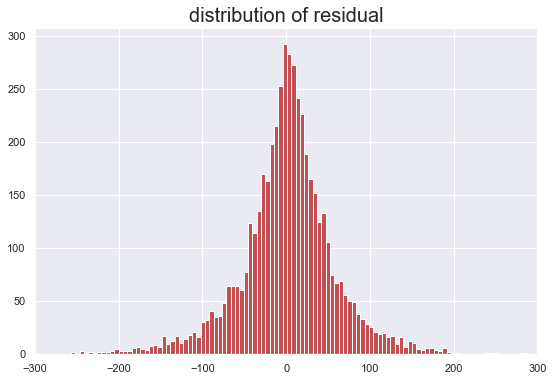

In [75]:
plt.figure(figsize=(9,6))
plt.hist(result_ar7.resid,bins=400,color='r')
plt.title('distribution of residual',size=20)
plt.xlim((-300,300))
plt.show()

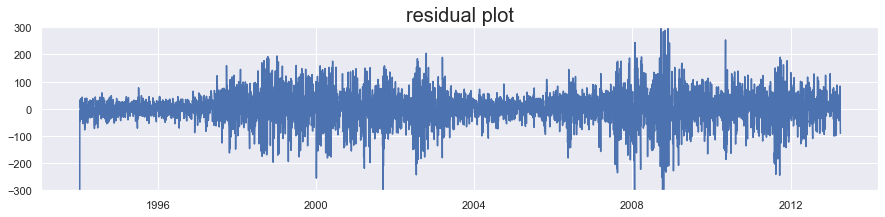

In [74]:
plt.plot(result_ar7.resid.index,result_ar7.resid.values)
plt.title('residual plot',size=20)
plt.ylim((-300,300))
plt.show()

In [37]:
mean=np.mean(result_ar7.resid)
mean

0.35175521811192206

In [38]:
std=np.std(result_ar7.resid)
std

63.29828056097564

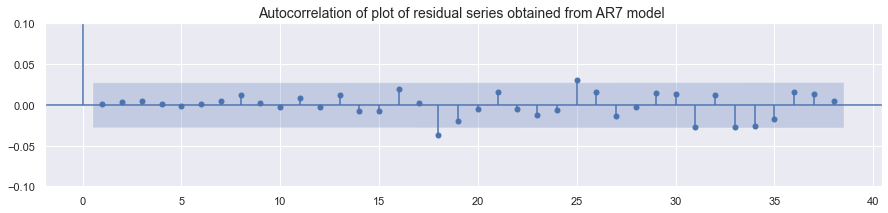

In [33]:
plt.rc('figure',figsize=(15,3))
sgt.plot_acf(result_ar7.resid)
plt.title('Autocorrelation of plot of residual series obtained from AR7 model ',size=14)
plt.ylim((-0.1,0.1))
plt.show()

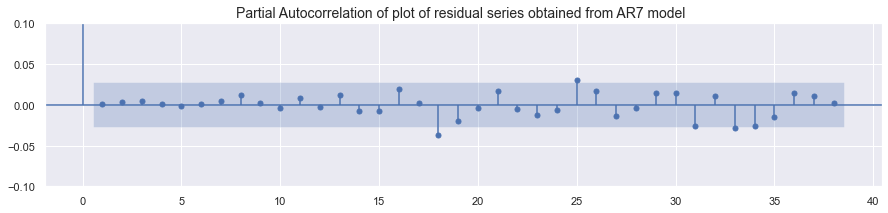

In [34]:
plt.rc('figure',figsize=(15,3))
sgt.plot_pacf(result_ar7.resid)
plt.title('Partial Autocorrelation of plot of residual series obtained from AR7 model ',size=14)
plt.ylim((-0.1,0.1))
plt.show()

In [44]:
ci = norm.interval(0.997, loc=mean, scale=std)
ci

(-187.50095261162005, 188.20446304784318)

#### ***Observation***
- Since p value of adfuller test of non stationarity is less than 0.05, So this residual are considered as stationary.
- Mean value of the residual are 0.35 which is near to zero.
- std value is 63.29.
- By observing the acf and  pacf plot it is clear that residual obtained from AR7 does not have any significant correlation with the past data. So it this residual series can be considered as white noice.
- All the white noice also resembles with normal/gaussian distribution.
- In gaussian distribution 68% of data falls around 1 std from mean. 95% data falls in 2-std. 99.7% of data falls in 3 std from mean.
- So 99.7% of time this residual will falls in range of (-187.500,188.20)
- Here confidence interval has derived by following formula ( mu - 3 * std , mu + 3 * std)
- The reason why std/sqrt(sizeofdata) has not used here cause we know population parameter.